In [10]:
import yaml
from joblib import load
import pandas as pd
from backend.utils.data_preprocessor import DataPreprocessor

with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = "1h"
lookback_period: int = config['preprocess']['lookback_period']
trend_length: int = config['preprocess']['trend_length']
target_column: str = config['preprocess']['target_column']
testing_file_path: str = f"../data/twelvedata/feature time series ({interval})/TSLA_feature_time_series.csv"
testing_df: pd.DataFrame = pd.read_csv(testing_file_path)


In [11]:
testing_preprocessor = DataPreprocessor(testing_df, lookback_period, target_column, trend_length)

X_test: [[[float]]] = testing_preprocessor.target_data_batched
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
y_test: [float] = testing_preprocessor.target_data_batched_labels


In [12]:
scaler = load('scaler.save')# load whole scaler.save

X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)


In [13]:
print("Testing Dataset shape:", testing_df.shape)
print("Testing Dataset as time series batches:",X_test.shape, y_test.shape)
# %run ../tests/data_preprocessor_validator.py
testing_preprocessor.target_data[['close', 'ema', 'target change', 'target trend', 'target']]

Testing Dataset shape: (4970, 41)
Testing Dataset as time series batches: (4960, 9, 42) (4960,)


,close,ema,target change,target trend,target
datetime,,,,,
2021-03-15 11:30:00,701.45,692.2911,0.0042,1,1
2021-03-15 12:30:00,701.59,694.5367,0.0032,1,1
2021-03-15 13:30:00,705.66,695.9656,0.0021,1,1
2021-03-15 14:30:00,703.93,697.7167,0.0025,1,1
2021-03-15 15:30:00,707.94,700.3944,0.0038,1,1
...,...,...,...,...,...
2024-01-09 11:30:00,234.92,237.6522,-0.0009,0,0
2024-01-09 12:30:00,234.15,237.1944,-0.0019,0,0
2024-01-09 13:30:00,233.90,236.6044,-0.0025,0,0


In [14]:
from keras.models import load_model
from backend.utils.model_evaluator import ModelEvaluator

model_path: str = "../models/saved models/trained_StockTrendLSTM_model.keras"
model = load_model(model_path)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
y_pred_prob: [float] = model.predict(X_test_scaled).flatten()
y_pred: [int] = (y_pred_prob > 0.5).astype(int)

model_evaluator = ModelEvaluator(test_loss, y_test, y_pred)
metrics_df = model_evaluator.evaluation_metrics
metrics_df

155/155 [==============================] - 1s 3ms/step


,Metric,Score
0,Loss,0.363487
1,Accuracy,0.848589
2,Precision,0.827048
3,Recall,0.879660
4,F1Score,0.852543
5,ROC AUC,0.848738


In [15]:
results_df: pd.DataFrame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Predicted_Prob': y_pred_prob})
results_df.describe()

,Actual,Predicted,Predicted_Prob
count,4960.000000,4960.000000,4960.000000
mean,0.497581,0.529234,0.530307
std,0.500045,0.499195,0.388775
min,0.000000,0.000000,0.004295
25%,0.000000,0.000000,0.096232
50%,0.000000,1.000000,0.584103
75%,1.000000,1.000000,0.935849
max,1.000000,1.000000,0.995429


In [16]:
increase_threshold: float = 0.9
decrease_threshold: float = 0.1
high_increase_prob = results_df['Predicted_Prob'] > increase_threshold
high_decrease_prob = results_df['Predicted_Prob'] < decrease_threshold
consolidation_prob = ((increase_threshold >= results_df['Predicted_Prob']) & (results_df['Predicted_Prob'] >= decrease_threshold))

high_increase_df = results_df[high_increase_prob]
high_decrease_df = results_df[high_decrease_prob]
consolidation_df = results_df[consolidation_prob]
increase_value_counts = high_increase_df['Actual'].value_counts(normalize=True)
decrease_value_counts = high_decrease_df['Actual'].value_counts(normalize=True)
consolidation_value_counts = consolidation_df['Actual'].value_counts(normalize=True)


print(high_increase_df.shape)
print(high_decrease_df.shape)
print(consolidation_df.shape)

print(increase_value_counts)
print(decrease_value_counts)
print(consolidation_value_counts)

high_increase_df

(1561, 3)
(1257, 3)
(2142, 3)
Actual
1    0.943626
0    0.056374
Name: proportion, dtype: float64
Actual
0    0.943516
1    0.056484
Name: proportion, dtype: float64
Actual
0    0.568627
1    0.431373
Name: proportion, dtype: float64


,Actual,Predicted,Predicted_Prob
26,1,1,0.975780
27,1,1,0.985485
28,1,1,0.989813
29,1,1,0.982310
30,1,1,0.956382
...,...,...,...
4901,1,1,0.932253
4902,1,1,0.910042
4903,1,1,0.965331
4951,1,1,0.916123


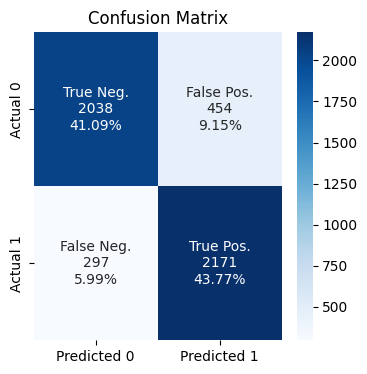

In [17]:
from backend.utils.visualizing_service import plot_confusion_matrix
plot_confusion_matrix(y_test, y_pred)

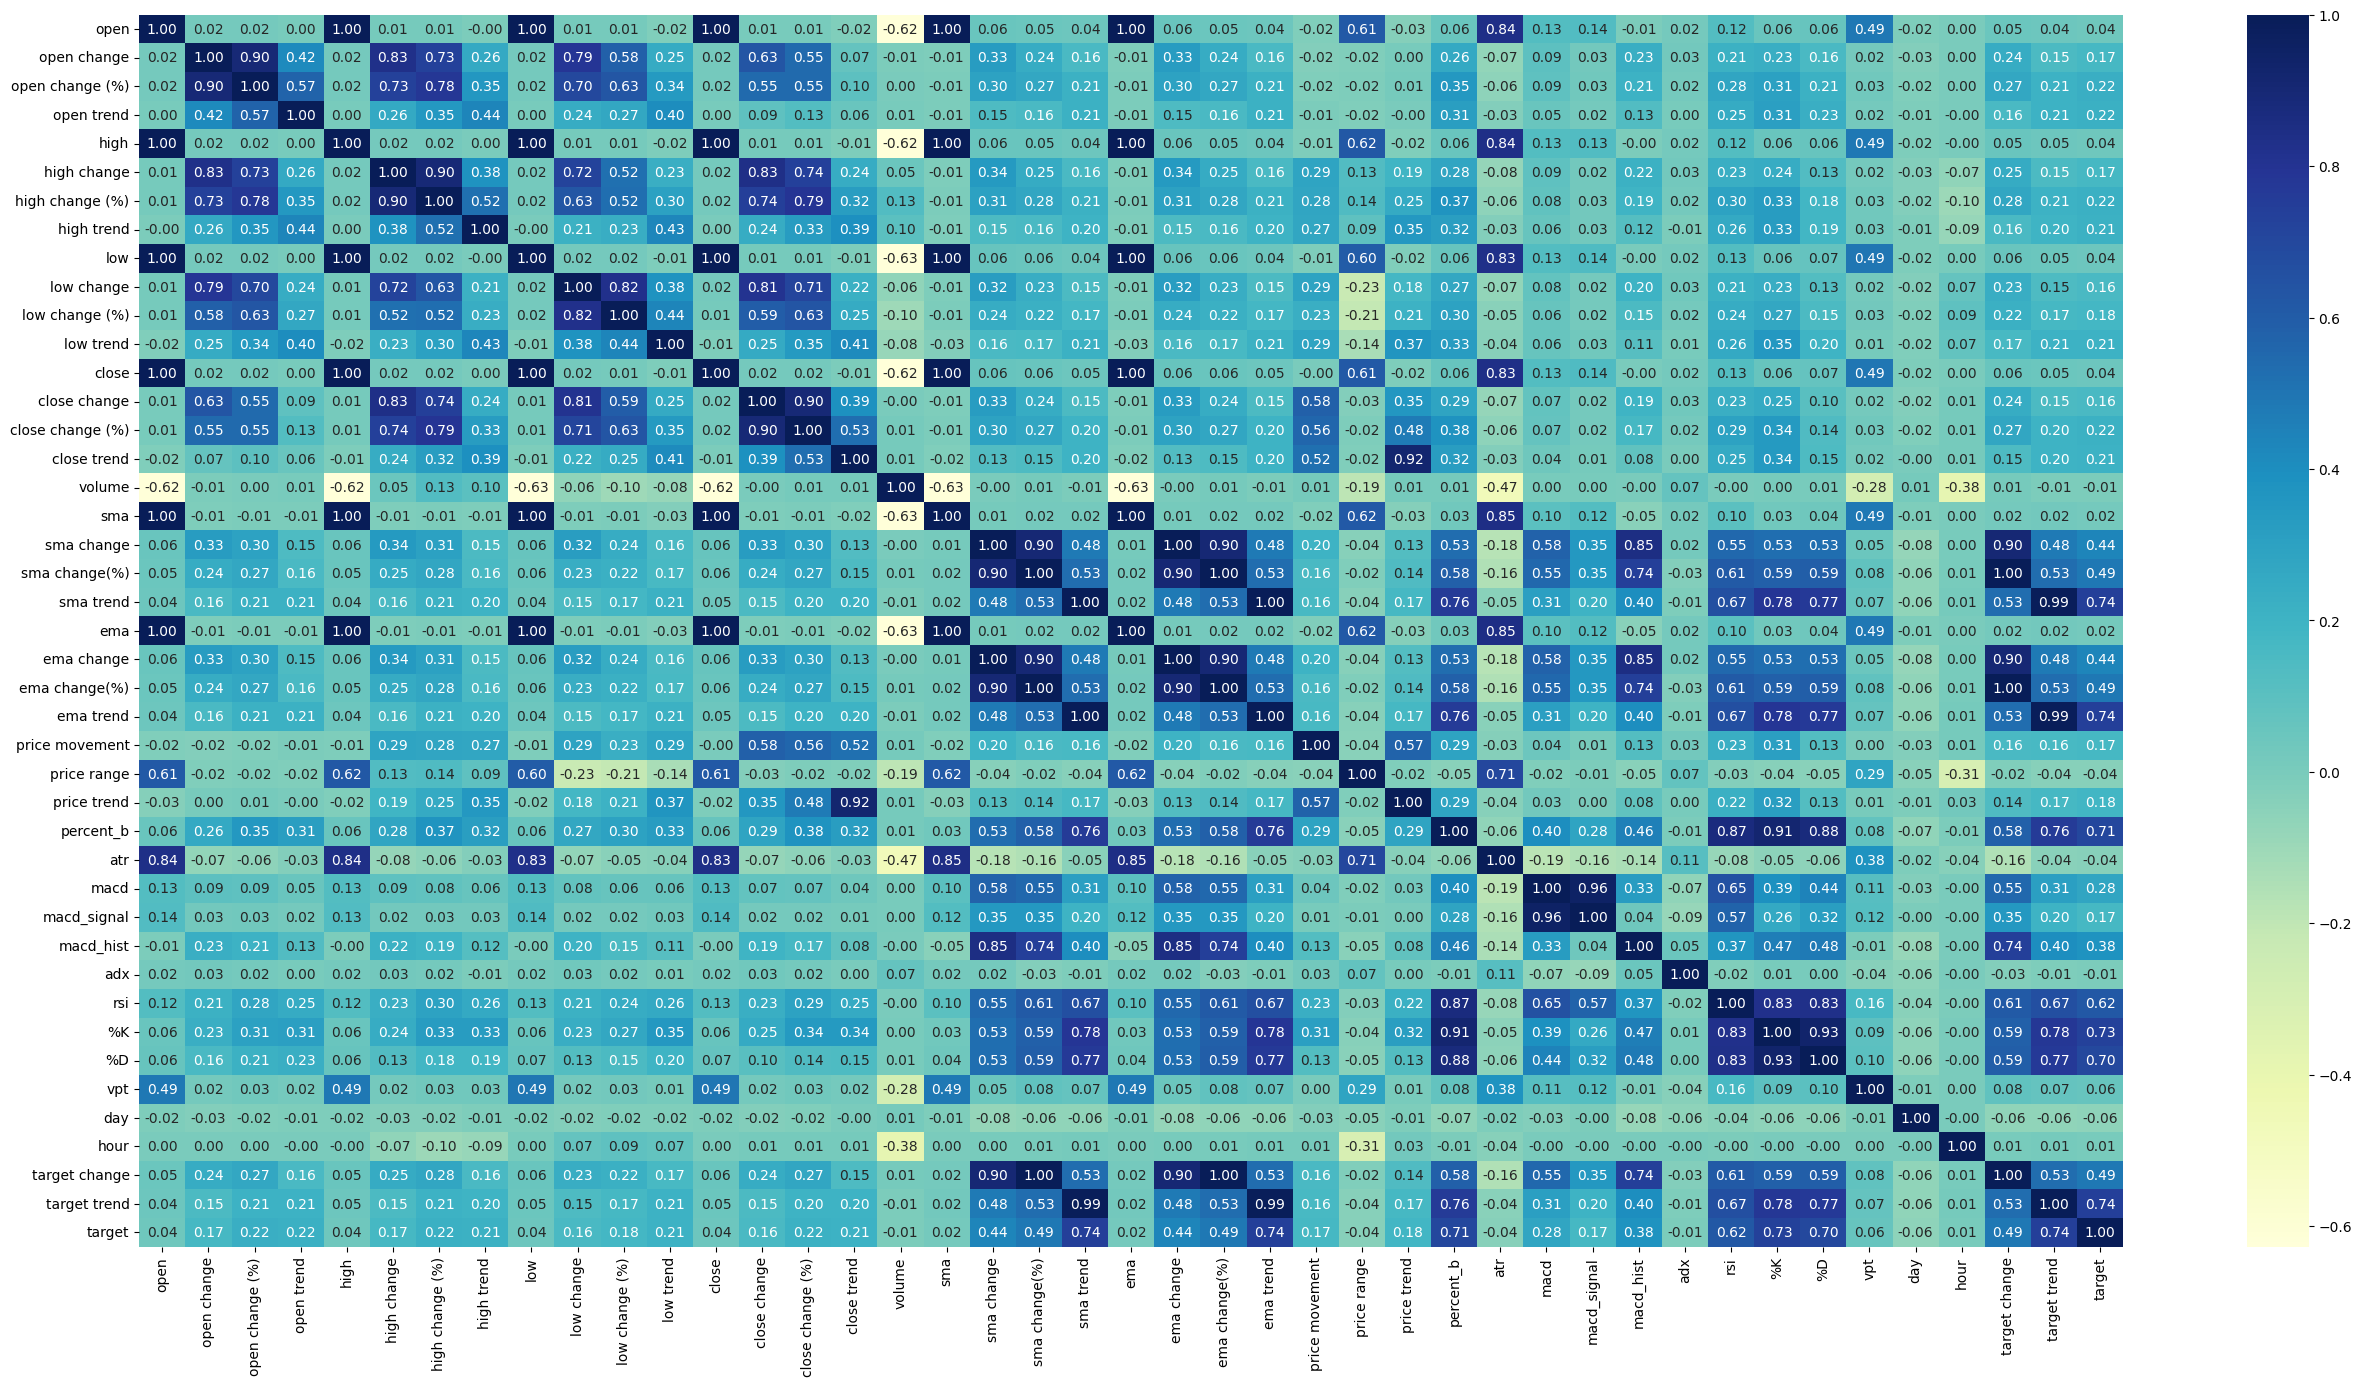

In [18]:
from backend.utils.visualizing_service import plot_correlation_heatmap
plot_correlation_heatmap(testing_preprocessor.target_data)
